In [35]:
#Import section
import pandas as pd
from dotenv import load_dotenv
import os
import requests
import hvplot.pandas
import numpy as np
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import seaborn as sns
import pandas_ta as ta

In [5]:
#Load devenv so I can load in the environment variables

load_dotenv()

True

## Getting Bitcoin Data

In [6]:
APCA_API_KEY_ID = os.getenv("ALPACA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

In [7]:
#Create request object for the alpaca crypto api, need to use requests as the SDK does not support the crypto API, getting one day data on BTC

symbol = "BTCUSD"
base_url = "https://data.alpaca.markets/v1beta1/crypto/"
request_url = "/bars"

url = base_url + symbol + request_url
params = { "start" : "2015-12-01",
           "limit" : 10000,
           "timeframe" : "1Day",
           "exchanges" : "CBSE"
}




headers = {'APCA-API-KEY-ID': APCA_API_KEY_ID, "APCA-API-SECRET-KEY": APCA_API_SECRET_KEY}

In [8]:
#Run the request
r = requests.request("Get", url, params=params, headers=headers)

In [9]:
#Convert request into jason object temp
temp = r.json()

In [10]:
#Just making sure we have something
temp

{'bars': [{'t': '2015-12-01T06:00:00Z',
   'x': 'CBSE',
   'o': 362.68,
   'h': 362.68,
   'l': 347.55,
   'c': 354.48,
   'v': 3629.51795307,
   'n': 3975,
   'vw': 352.8784820615},
  {'t': '2015-12-02T06:00:00Z',
   'x': 'CBSE',
   'o': 360,
   'h': 369.99,
   'l': 358.68,
   'c': 368.58,
   'v': 2319.04212203,
   'n': 2328,
   'vw': 365.4406886907},
  {'t': '2015-12-03T06:00:00Z',
   'x': 'CBSE',
   'o': 361.89,
   'h': 362.81,
   'l': 355.43,
   'c': 359.34,
   'v': 1512.27649251,
   'n': 3134,
   'vw': 359.2292817314},
  {'t': '2015-12-04T06:00:00Z',
   'x': 'CBSE',
   'o': 359.54,
   'h': 364.85,
   'l': 358.41,
   'c': 363.98,
   'v': 4352.4291564,
   'n': 8347,
   'vw': 361.9621024854},
  {'t': '2015-12-05T06:00:00Z',
   'x': 'CBSE',
   'o': 388.03,
   'h': 401.01,
   'l': 387,
   'c': 398,
   'v': 4046.00911919,
   'n': 11232,
   'vw': 394.0852476648},
  {'t': '2015-12-06T06:00:00Z',
   'x': 'CBSE',
   'o': 387.53,
   'h': 392.84,
   'l': 383,
   'c': 387.39,
   'v': 1411.7445

In [11]:
#putting the BTC data into a dataframe
df = pd.DataFrame(temp["bars"])

In [12]:
#Making things look pretty
df = df.rename(columns={'t': 'Date', 'x': 'Exchange', "o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume", "n": "Number of Trades", "vw": "Volume Weighted Average Price"})
df['Date'] = df['Date'].str.replace(r'T06:00:00Z', '')
df['Date'] = df['Date'].str.replace(r'T05:00:00Z', '')

In [13]:
#Checking to make sure we have a good amount of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           2263 non-null   object 
 1   Exchange                       2263 non-null   object 
 2   Open                           2263 non-null   float64
 3   High                           2263 non-null   float64
 4   Low                            2263 non-null   float64
 5   Close                          2263 non-null   float64
 6   Volume                         2263 non-null   float64
 7   Number of Trades               2263 non-null   int64  
 8   Volume Weighted Average Price  2263 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 159.2+ KB


In [14]:
#getting rid of what I don't need
df.drop(columns=["Open", "High", "Low", "Exchange", "Volume", "Number of Trades", "Volume Weighted Average Price"], inplace=True)

In [15]:
#Doing that index thing
df['Datetime'] = pd.to_datetime(df['Date'])
df = df.set_index('Datetime')
df.drop(columns=["Date"], inplace=True)

In [16]:
#Making sure it all looks pretty and has that index thing
df

,Close
Datetime,
2015-12-01,354.48
2015-12-02,368.58
2015-12-03,359.34
2015-12-04,363.98
2015-12-05,398.00
...,...
2022-02-05,41610.64
2022-02-06,42835.99
2022-02-07,44916.93


In [17]:
#plot of BTC price data
df.hvplot.line(width=1400)

:Curve   [Datetime]   (Close)

In [18]:
#Ploting 30 day rolling STD (volatility)
df.rolling(30).std().hvplot(width=1400)

:Curve   [Datetime]   (Close)

In [22]:
#used later for TA-Lib
df_btc_TA_Lib = df.copy()

## 50 Day SMA Strat

In [37]:
#Copying dataframe to use for 50 day sma idea
df_btc_50day = df.copy()

In [38]:
#Calculating the 50 day SMA
df_btc_50day["SMA50"] = ta.sma(df_btc_50day["Close"], length=50)

In [39]:
#Dropping the empty data
df_btc_50day.dropna()

,Close,SMA50
Datetime,,
2016-01-19,379.96,423.5026
2016-01-20,418.54,424.7838
2016-01-21,399.10,425.3942
2016-01-22,382.90,425.8654
2016-01-23,390.09,426.3876
...,...,...
2022-02-05,41610.64,42883.5732
2022-02-06,42835.99,42787.7942
2022-02-07,44916.93,42757.4512


In [40]:
#ploting price and 50 day SMA
df_btc_50day.hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [20]:
#Calculating our position based on the 50 Day moving average
df_btc_50day["Position"] = np.where(df_btc_50day["SMA50"] < df_btc_50day["Close"], 1, -1)

In [21]:
#Dropping nulls
df_btc_50day.dropna(inplace=True)

In [22]:
#making sure we have something to look at
df_btc_50day

,Close,SMA50,Position
Datetime,,,
2016-01-19,379.96,423.5026,-1
2016-01-20,418.54,424.7838,-1
2016-01-21,399.10,425.3942,-1
2016-01-22,382.90,425.8654,-1
2016-01-23,390.09,426.3876,-1
...,...,...,...
2022-02-05,41610.64,42883.5732,-1
2022-02-06,42835.99,42787.7942,1
2022-02-07,44916.93,42757.4512,1


In [23]:
#Graphing position, long or short
df_btc_50day["Position"].hvplot.line(width=1400)

:Curve   [Datetime]   (Position)

In [24]:
#Calc and displaying return data for bitcoin itself
df_btc_50day["Returns"] = df_btc_50day["Close"].pct_change()
df_btc_50day

,Close,SMA50,Position,Returns
Datetime,,,,
2016-01-19,379.96,423.5026,-1,NaN
2016-01-20,418.54,424.7838,-1,0.101537
2016-01-21,399.10,425.3942,-1,-0.046447
2016-01-22,382.90,425.8654,-1,-0.040591
2016-01-23,390.09,426.3876,-1,0.018778
...,...,...,...,...
2022-02-05,41610.64,42883.5732,-1,0.001278
2022-02-06,42835.99,42787.7942,1,0.029448
2022-02-07,44916.93,42757.4512,1,0.048579


In [25]:
#ploting returns of bitcoin itself
df_btc_50day["Returns"].hvplot(width=1400)

:Curve   [Datetime]   (Returns)

In [26]:
#Calculating returns for strat and displaying data
df_btc_50day["Strat"] = df_btc_50day["Position"].shift(1) * df_btc_50day["Returns"]
df_btc_50day

,Close,SMA50,Position,Returns,Strat
Datetime,,,,,
2016-01-19,379.96,423.5026,-1,NaN,NaN
2016-01-20,418.54,424.7838,-1,0.101537,-0.101537
2016-01-21,399.10,425.3942,-1,-0.046447,0.046447
2016-01-22,382.90,425.8654,-1,-0.040591,0.040591
2016-01-23,390.09,426.3876,-1,0.018778,-0.018778
...,...,...,...,...,...
2022-02-05,41610.64,42883.5732,-1,0.001278,-0.001278
2022-02-06,42835.99,42787.7942,1,0.029448,-0.029448
2022-02-07,44916.93,42757.4512,1,0.048579,0.048579


In [27]:
#ploting returns of strat
df_btc_50day["Strat"].hvplot(width=1400)

:Curve   [Datetime]   (Strat)

In [28]:
#Viewing the exponential logarithmic returns between the BTC and the 50 day strat
df_btc_50day[["Returns", "Strat"]].cumsum().apply(np.exp).hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [29]:
#Doing that calc-y thing again and getting cumulative returns this time
cumulative_returns = (1 + df_btc_50day["Returns"]).cumprod() - 1
cumulative_returns = pd.DataFrame(cumulative_returns)
cumulative_returns = cumulative_returns.rename(columns={'Returns': 'BTC Returns'})
cumulative_returns["Strat Returns"] = (1 + df_btc_50day["Strat"]).cumprod() - 1
cumulative_returns

,BTC Returns,Strat Returns
Datetime,,
2016-01-19,NaN,NaN
2016-01-20,0.101537,-0.101537
2016-01-21,0.050374,-0.059806
2016-01-22,0.007738,-0.021642
2016-01-23,0.026661,-0.040014
...,...,...
2022-02-05,108.513212,34.053711
2022-02-06,111.738157,33.021449
2022-02-07,117.214891,34.674186


In [30]:
#Graphy graphy dat data
cumulative_returns.hvplot(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [95]:
#Calc STD on returns so we can then calc sharpe ratio
SMA50_portfolio_std= df_btc_50day[["Returns", "Strat"]].std()
SMA50_portfolio_std

Returns    0.041562
Strat      0.041599
dtype: float64

In [98]:
sharpe_ratios_50 = (SMA50_portfolio_std.mean() * 365) / (SMA50_portfolio_std * np.sqrt(365))
sharpe_ratios_50.head()

Returns    19.113310
Strat      19.096643
dtype: float64

### 20 Day Moving Average Strat

In [41]:
#Starting 20 day moving average
df_btc_20day = df.copy()

In [42]:
#Calculating the 20 day SMA
df_btc_20day["SMA20"] = ta.sma(df_btc_20day["Close"], length=20)

In [43]:
#Dropping the empty data
df_btc_20day.dropna()

,Close,SMA20
Datetime,,
2015-12-20,442.22,417.2020
2015-12-21,436.62,421.3090
2015-12-22,437.66,424.7630
2015-12-23,455.71,429.5815
2015-12-24,455.74,434.1695
...,...,...
2022-02-05,41610.64,38280.0200
2022-02-06,42835.99,38315.5320
2022-02-07,44916.93,38471.9435


In [44]:
#ploting price and 20 day SMA
df_btc_20day.hvplot.line(width=1400)


:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [35]:
#Calculating our position based on the 20 Day moving average
df_btc_20day["Position"] = np.where(df_btc_20day["SMA20"] < df_btc_20day["Close"], 1, -1)

In [36]:
#drop nulls
df_btc_20day.dropna(inplace=True)

In [37]:
#making sure we have something to look at
df_btc_20day

,Close,SMA20,Position
Datetime,,,
2015-12-20,442.22,417.2020,1
2015-12-21,436.62,421.3090,1
2015-12-22,437.66,424.7630,1
2015-12-23,455.71,429.5815,1
2015-12-24,455.74,434.1695,1
...,...,...,...
2022-02-05,41610.64,38280.0200,1
2022-02-06,42835.99,38315.5320,1
2022-02-07,44916.93,38471.9435,1


In [38]:
#Graphing position, long or short
df_btc_20day["Position"].hvplot.line(width=1300)

:Curve   [Datetime]   (Position)

In [39]:
#Calc and displaying return data for bitcoin itself
df_btc_20day["Returns"] = df_btc_20day["Close"].pct_change()
df_btc_20day

,Close,SMA20,Position,Returns
Datetime,,,,
2015-12-20,442.22,417.2020,1,NaN
2015-12-21,436.62,421.3090,1,-0.012663
2015-12-22,437.66,424.7630,1,0.002382
2015-12-23,455.71,429.5815,1,0.041242
2015-12-24,455.74,434.1695,1,0.000066
...,...,...,...,...
2022-02-05,41610.64,38280.0200,1,0.001278
2022-02-06,42835.99,38315.5320,1,0.029448
2022-02-07,44916.93,38471.9435,1,0.048579


In [40]:
#Calculating returns for strat and displaying data
df_btc_20day["Strat"] = df_btc_20day["Position"].shift(1) * df_btc_20day["Returns"]
df_btc_20day

,Close,SMA20,Position,Returns,Strat
Datetime,,,,,
2015-12-20,442.22,417.2020,1,NaN,NaN
2015-12-21,436.62,421.3090,1,-0.012663,-0.012663
2015-12-22,437.66,424.7630,1,0.002382,0.002382
2015-12-23,455.71,429.5815,1,0.041242,0.041242
2015-12-24,455.74,434.1695,1,0.000066,0.000066
...,...,...,...,...,...
2022-02-05,41610.64,38280.0200,1,0.001278,0.001278
2022-02-06,42835.99,38315.5320,1,0.029448,0.029448
2022-02-07,44916.93,38471.9435,1,0.048579,0.048579


In [41]:
#ploting returns of strat
df_btc_20day["Strat"].hvplot(width=1400)

:Curve   [Datetime]   (Strat)

In [42]:
#Viewing the exponential logarithmic returns between the BTC and the 50 day strat
df_btc_20day[["Returns", "Strat"]].cumsum().apply(np.exp).hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [43]:
#Doing that calc-y thing again and getting cumulative returns this time
cumulative_returns_20 = (1 + df_btc_20day["Returns"]).cumprod() - 1
cumulative_returns_20 = pd.DataFrame(cumulative_returns_20)
cumulative_returns_20 = cumulative_returns_20.rename(columns={'Returns': 'BTC Returns'})
cumulative_returns_20["Strat Returns"] = (1 + df_btc_20day["Strat"]).cumprod() - 1
cumulative_returns_20

,BTC Returns,Strat Returns
Datetime,,
2015-12-20,NaN,NaN
2015-12-21,-0.012663,-0.012663
2015-12-22,-0.010312,-0.010312
2015-12-23,0.030505,0.030505
2015-12-24,0.030573,0.030573
...,...,...
2022-02-05,93.094885,5.270900
2022-02-06,95.865791,5.455566
2022-02-07,100.571458,5.769172


In [44]:
#Graphy graphy dat data
cumulative_returns_20.hvplot(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [97]:
#Calc STD on returns so we can then calc sharpe ratio
SMA20_portfolio_std= df_btc_20day[["Returns", "Strat"]].std()
SMA20_portfolio_std

Returns    0.041513
Strat      0.041581
dtype: float64

In [ ]:
#Sharpe ratio
sharpe_ratios_50 = (SMA50_portfolio_std.mean() * 365) / (SMA50_portfolio_std * np.sqrt(365))
sharpe_ratios_50.head()

## 4 Day EMA

In [45]:
#Starting 4 day ema strategy
df_btc_4dayEMA = df.copy()

In [46]:
#Calculating the 4 day EMA
df_btc_4dayEMA["4EMA"] = df_btc_4dayEMA["Close"].ewm(span=4, adjust=False).mean()

In [47]:
#Dropping the empty data
df_btc_4dayEMA.dropna()

,Close,4EMA
Datetime,,
2015-12-01,354.48,354.480000
2015-12-02,368.58,360.120000
2015-12-03,359.34,359.808000
2015-12-04,363.98,361.476800
2015-12-05,398.00,376.086080
...,...,...
2022-02-05,41610.64,40157.387024
2022-02-06,42835.99,41228.828215
2022-02-07,44916.93,42704.068929


In [48]:
#ploting price and 4 day EMA
df_btc_4dayEMA.hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [49]:
#calulating our positions
df_btc_4dayEMA["Position"] = np.where(df_btc_4dayEMA["4EMA"] < df_btc_4dayEMA["Close"], 1, -1)
df_btc_4dayEMA.dropna(inplace=True)
#making sure we have something to look at
df_btc_4dayEMA

,Close,4EMA,Position
Datetime,,,
2015-12-01,354.48,354.480000,-1
2015-12-02,368.58,360.120000,1
2015-12-03,359.34,359.808000,-1
2015-12-04,363.98,361.476800,1
2015-12-05,398.00,376.086080,1
...,...,...,...
2022-02-05,41610.64,40157.387024,1
2022-02-06,42835.99,41228.828215,1
2022-02-07,44916.93,42704.068929,1


In [50]:
#plotting our position
df_btc_4dayEMA["Position"].hvplot.line(width=1400)

:Curve   [Datetime]   (Position)

In [51]:
df_btc_4dayEMA["Returns"] = df_btc_4dayEMA["Close"].pct_change()
df_btc_4dayEMA

,Close,4EMA,Position,Returns
Datetime,,,,
2015-12-01,354.48,354.480000,-1,NaN
2015-12-02,368.58,360.120000,1,0.039777
2015-12-03,359.34,359.808000,-1,-0.025069
2015-12-04,363.98,361.476800,1,0.012913
2015-12-05,398.00,376.086080,1,0.093467
...,...,...,...,...
2022-02-05,41610.64,40157.387024,1,0.001278
2022-02-06,42835.99,41228.828215,1,0.029448
2022-02-07,44916.93,42704.068929,1,0.048579


In [52]:
#Calculating returns for strat and displaying data
df_btc_4dayEMA["Strat"] = df_btc_4dayEMA["Position"].shift(1) * df_btc_4dayEMA["Returns"]
df_btc_4dayEMA

,Close,4EMA,Position,Returns,Strat
Datetime,,,,,
2015-12-01,354.48,354.480000,-1,NaN,NaN
2015-12-02,368.58,360.120000,1,0.039777,-0.039777
2015-12-03,359.34,359.808000,-1,-0.025069,-0.025069
2015-12-04,363.98,361.476800,1,0.012913,-0.012913
2015-12-05,398.00,376.086080,1,0.093467,0.093467
...,...,...,...,...,...
2022-02-05,41610.64,40157.387024,1,0.001278,0.001278
2022-02-06,42835.99,41228.828215,1,0.029448,0.029448
2022-02-07,44916.93,42704.068929,1,0.048579,0.048579


In [53]:
#ploting returns of strat
df_btc_4dayEMA["Strat"].hvplot(width=1400)

:Curve   [Datetime]   (Strat)

In [54]:
#Viewing the exponential logarithmic returns between the BTC and the 50 day strat
df_btc_4dayEMA[["Returns", "Strat"]].cumsum().apply(np.exp).hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [55]:
#Doing that calc-y thing again and getting cumulative returns this time
cumulative_returns_50 = (1 + df_btc_4dayEMA["Returns"]).cumprod() - 1
cumulative_returns_50 = pd.DataFrame(cumulative_returns_50)
cumulative_returns_50 = cumulative_returns_50.rename(columns={'Returns': 'BTC Returns'})
cumulative_returns_50["Strat Returns"] = (1 + df_btc_4dayEMA["Strat"]).cumprod() - 1
cumulative_returns_50

,BTC Returns,Strat Returns
Datetime,,
2015-12-01,NaN,NaN
2015-12-02,0.039777,-0.039777
2015-12-03,0.013710,-0.063849
2015-12-04,0.026800,-0.075937
2015-12-05,0.122771,0.010432
...,...,...
2022-02-05,116.385015,4.067867
2022-02-06,119.841768,4.217106
2022-02-07,125.712170,4.470549


In [56]:
#Graphy graphy dat data
cumulative_returns_50.hvplot(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [ ]:
#Calc STD on returns so we can then calc sharpe ratio
EMA4_portfolio_std= df_btc_4dayEMA[["Returns", "Strat"]].std()
EMA4_portfolio_std

In [ ]:
#Sharpe ratio
sharpe_ratios_4EMA = (EMA4_portfolio_std.mean() * 365) / (EMA4_portfolio_std * np.sqrt(365))
sharpe_ratios_4EMA.head()

## 20 Day/50 Day crossover Strat

In [57]:
#Copying dataframe to use for crossover strat
df_btc_crossover = df.copy()

In [58]:
#Calculating the 50 day SMA
df_btc_crossover["SMA50"] = df_btc_crossover["Close"].rolling(50).mean()

In [59]:
#Calculating the 20 day SMA
df_btc_crossover["SMA20"] = df_btc_crossover["Close"].rolling(20).mean()

In [60]:
#Dropping the empty data
df_btc_crossover.dropna()

,Close,SMA50,SMA20
Datetime,,,
2016-01-19,379.96,423.5026,424.1025
2016-01-20,418.54,424.7838,423.2300
2016-01-21,399.10,425.3942,421.4020
2016-01-22,382.90,425.8654,418.7770
2016-01-23,390.09,426.3876,416.6860
...,...,...,...
2022-02-05,41610.64,42883.5732,38280.0200
2022-02-06,42835.99,42787.7942,38315.5320
2022-02-07,44916.93,42757.4512,38471.9435


In [61]:
df_btc_crossover.hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [62]:
#Calculating our position based on the 50 Day moving average and 20 day moving average crossover
df_btc_crossover["Position"] = np.where(df_btc_crossover["SMA50"] < df_btc_crossover["SMA20"], 1, -1)

In [63]:
#Dropping nulls
df_btc_crossover.dropna(inplace=True)

In [64]:
#Making sure we have something to look at
df_btc_crossover

,Close,SMA50,SMA20,Position
Datetime,,,,
2016-01-19,379.96,423.5026,424.1025,1
2016-01-20,418.54,424.7838,423.2300,-1
2016-01-21,399.10,425.3942,421.4020,-1
2016-01-22,382.90,425.8654,418.7770,-1
2016-01-23,390.09,426.3876,416.6860,-1
...,...,...,...,...
2022-02-05,41610.64,42883.5732,38280.0200,-1
2022-02-06,42835.99,42787.7942,38315.5320,-1
2022-02-07,44916.93,42757.4512,38471.9435,-1


In [65]:
#Graphing position, long or short
df_btc_crossover["Position"].hvplot.line(width=1400)

:Curve   [Datetime]   (Position)

In [68]:
#Calcing returns
df_btc_crossover["Returns"] = df_btc_crossover["Close"].pct_change()
df_btc_crossover

,Close,SMA50,SMA20,Position,Returns
Datetime,,,,,
2016-01-19,379.96,423.5026,424.1025,1,NaN
2016-01-20,418.54,424.7838,423.2300,-1,0.101537
2016-01-21,399.10,425.3942,421.4020,-1,-0.046447
2016-01-22,382.90,425.8654,418.7770,-1,-0.040591
2016-01-23,390.09,426.3876,416.6860,-1,0.018778
...,...,...,...,...,...
2022-02-05,41610.64,42883.5732,38280.0200,-1,0.001278
2022-02-06,42835.99,42787.7942,38315.5320,-1,0.029448
2022-02-07,44916.93,42757.4512,38471.9435,-1,0.048579


In [69]:
#Calculating returns for strat and displaying data
df_btc_crossover["Strat"] = df_btc_crossover["Position"].shift(1) * df_btc_crossover["Returns"]
df_btc_crossover

,Close,SMA50,SMA20,Position,Returns,Strat
Datetime,,,,,,
2016-01-19,379.96,423.5026,424.1025,1,NaN,NaN
2016-01-20,418.54,424.7838,423.2300,-1,0.101537,0.101537
2016-01-21,399.10,425.3942,421.4020,-1,-0.046447,0.046447
2016-01-22,382.90,425.8654,418.7770,-1,-0.040591,0.040591
2016-01-23,390.09,426.3876,416.6860,-1,0.018778,-0.018778
...,...,...,...,...,...,...
2022-02-05,41610.64,42883.5732,38280.0200,-1,0.001278,-0.001278
2022-02-06,42835.99,42787.7942,38315.5320,-1,0.029448,-0.029448
2022-02-07,44916.93,42757.4512,38471.9435,-1,0.048579,-0.048579


In [70]:
#ploting returns of strat
df_btc_crossover["Strat"].hvplot(width=1400)

:Curve   [Datetime]   (Strat)

In [71]:
#Viewing the exponential logarithmic returns between the BTC and the 50 day strat
df_btc_crossover[["Returns", "Strat"]].cumsum().apply(np.exp).hvplot.line(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [72]:
#Doing that calc-y thing again and getting cumulative returns this time
cumulative_returns_cross = (1 + df_btc_crossover["Returns"]).cumprod() - 1
cumulative_returns_cross = pd.DataFrame(cumulative_returns_cross)
cumulative_returns_cross = cumulative_returns_cross.rename(columns={'Returns': 'BTC Returns'})
cumulative_returns_cross["Strat Returns"] = (1 + df_btc_crossover["Strat"]).cumprod() - 1
cumulative_returns_cross

,BTC Returns,Strat Returns
Datetime,,
2016-01-19,NaN,NaN
2016-01-20,0.101537,0.101537
2016-01-21,0.050374,0.152700
2016-01-22,0.007738,0.199490
2016-01-23,0.026661,0.176966
...,...,...
2022-02-05,108.513212,19.623821
2022-02-06,111.738157,19.016491
2022-02-07,117.214891,18.044105


In [73]:
#Graphy graphy dat data
cumulative_returns_cross.hvplot(width=1400)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)

In [ ]:
#Calc STD on returns so we can then calc sharpe ratio
cross_portfolio_std= df_btc_crossover[["Returns", "Strat"]].std()
cross_portfolio_std

In [ ]:
#Sharpe ratio
sharpe_ratios_cross = (cross_portfolio_std.mean() * 365) / (cross_portfolio_std * np.sqrt(365))
sharpe_ratios_cross.head()

## BTC correlation to S&P500 and Nasdaq (QQQ)

In [74]:
#Create request for SPY data

symbol = "SPY"
base_url = "https://data.alpaca.markets/v2/stocks/"
request_url = "/bars"

url = base_url + symbol + request_url
params = { "start" : "2015-01-01",
           "limit" : 10000,
           "timeframe" : "1Day",

}
headers = {'APCA-API-KEY-ID': APCA_API_KEY_ID, "APCA-API-SECRET-KEY": APCA_API_SECRET_KEY}

In [75]:
r = requests.request("Get", url, params=params, headers=headers)

In [76]:
temp = r.json()

In [77]:
#Just making sure we have something
temp

{'bars': [{'t': '2015-12-01T05:00:00Z',
   'o': 209.42,
   'h': 210.82,
   'l': 209.11,
   'c': 210.68,
   'v': 97858418,
   'n': 337780,
   'vw': 209.92141},
  {'t': '2015-12-02T05:00:00Z',
   'o': 210.63,
   'h': 211,
   'l': 208.23,
   'c': 208.529,
   'v': 108069059,
   'n': 367013,
   'vw': 209.563055},
  {'t': '2015-12-03T05:00:00Z',
   'o': 208.9,
   'h': 209.15,
   'l': 204.7511,
   'c': 205.61,
   'v': 166224154,
   'n': 546768,
   'vw': 206.878936},
  {'t': '2015-12-04T05:00:00Z',
   'o': 206.1,
   'h': 209.97,
   'l': 205.93,
   'c': 209.62,
   'v': 192878747,
   'n': 556731,
   'vw': 208.178631},
  {'t': '2015-12-07T05:00:00Z',
   'o': 209.22,
   'h': 209.7295,
   'l': 207.2,
   'c': 208.35,
   'v': 102027111,
   'n': 374705,
   'vw': 208.276128},
  {'t': '2015-12-08T05:00:00Z',
   'o': 206.49,
   'h': 208.289,
   'l': 205.78,
   'c': 206.949,
   'v': 103372367,
   'n': 387782,
   'vw': 206.966276},
  {'t': '2015-12-09T05:00:00Z',
   'o': 206.2,
   'h': 208.68,
   'l': 204.

In [78]:
#putting the SPY data into a dataframe
df_SPY_Raw = pd.DataFrame(temp["bars"])

In [79]:
df_SPY_Raw


,t,o,h,l,c,v,n,vw
0,2015-12-01T05:00:00Z,209.420,210.8200,209.1100,210.680,97858418,337780,209.921410
1,2015-12-02T05:00:00Z,210.630,211.0000,208.2300,208.529,108069059,367013,209.563055
2,2015-12-03T05:00:00Z,208.900,209.1500,204.7511,205.610,166224154,546768,206.878936
3,2015-12-04T05:00:00Z,206.100,209.9700,205.9300,209.620,192878747,556731,208.178631
4,2015-12-07T05:00:00Z,209.220,209.7295,207.2000,208.350,102027111,374705,208.276128
...,...,...,...,...,...,...,...,...
1555,2022-02-03T05:00:00Z,450.910,452.9700,445.7100,446.600,117670723,1102873,449.830692
1556,2022-02-04T05:00:00Z,446.490,452.7800,443.8300,448.700,119546087,1159729,448.296907
1557,2022-02-07T05:00:00Z,449.715,450.9900,445.8500,447.260,84271700,757911,448.620815
1558,2022-02-08T05:00:00Z,446.795,451.9200,445.2200,450.940,80723600,683504,449.078419


In [80]:
#putting on makeup, looking all pretty and stuff
df_SPY_Raw = df_SPY_Raw.rename(columns={'t': 'Date',  "o": "Open", "h": "High", "l": "Low", "c": "SPY Close", "v": "Volume", "n": "Number of Trades", "vw": "Volume Weighted Average Price"})
df_SPY_Raw['Date'] = df_SPY_Raw['Date'].str.replace(r'T06:00:00Z', '')
df_SPY_Raw['Date'] = df_SPY_Raw['Date'].str.replace(r'T05:00:00Z', '')
df_SPY_Raw['Date'] = df_SPY_Raw['Date'].str.replace(r'T04:00:00Z', '')
df_SPY_Raw.drop(columns=["Open", "High", "Low", "Volume", "Number of Trades", "Volume Weighted Average Price"], inplace=True)
df_SPY_Raw['Datetime'] = pd.to_datetime(df_SPY_Raw['Date'])
df_SPY_Raw = df_SPY_Raw.set_index('Datetime')
df_SPY_Raw.drop(columns=["Date"], inplace=True)
df_SPY_Raw

,SPY Close
Datetime,
2015-12-01,210.680
2015-12-02,208.529
2015-12-03,205.610
2015-12-04,209.620
2015-12-07,208.350
...,...
2022-02-03,446.600
2022-02-04,448.700
2022-02-07,447.260


In [81]:
#Create request for SPY data

symbol = "QQQ"
base_url = "https://data.alpaca.markets/v2/stocks/"
request_url = "/bars"

url = base_url + symbol + request_url
params = { "start" : "2015-01-01",
           "limit" : 10000,
           "timeframe" : "1Day",

}
headers = {'APCA-API-KEY-ID': APCA_API_KEY_ID, "APCA-API-SECRET-KEY": APCA_API_SECRET_KEY}

In [82]:
r = requests.request("Get", url, params=params, headers=headers)

In [83]:
temp = r.json()

In [84]:
#Just making sure we have something
temp

{'bars': [{'t': '2015-12-01T05:00:00Z',
   'o': 114.48,
   'h': 115.16,
   'l': 114.34,
   'c': 115.16,
   'v': 28639345,
   'n': 92411,
   'vw': 114.737065},
  {'t': '2015-12-02T05:00:00Z',
   'o': 115.25,
   'h': 115.75,
   'l': 114.28,
   'c': 114.45,
   'v': 22395483,
   'n': 86021,
   'vw': 115.047568},
  {'t': '2015-12-03T05:00:00Z',
   'o': 114.76,
   'h': 114.96,
   'l': 111.8432,
   'c': 112.51,
   'v': 42712345,
   'n': 149940,
   'vw': 113.372592},
  {'t': '2015-12-04T05:00:00Z',
   'o': 112.85,
   'h': 115.33,
   'l': 112.62,
   'c': 115.14,
   'v': 40037322,
   'n': 144008,
   'vw': 114.263026},
  {'t': '2015-12-07T05:00:00Z',
   'o': 115.22,
   'h': 115.29,
   'l': 114.07,
   'c': 114.62,
   'v': 25871101,
   'n': 97939,
   'vw': 114.595314},
  {'t': '2015-12-08T05:00:00Z',
   'o': 113.42,
   'h': 114.995,
   'l': 113.38,
   'c': 114.63,
   'v': 30792648,
   'n': 121221,
   'vw': 114.315016},
  {'t': '2015-12-09T05:00:00Z',
   'o': 114.13,
   'h': 114.76,
   'l': 112.2,
 

In [85]:
#putting the QQQ data into a dataframe
df_QQQ_Raw = pd.DataFrame(temp["bars"])

In [86]:
#gotta do our hair, making it look all pretty and stuff
df_QQQ_Raw = df_QQQ_Raw.rename(columns={'t': 'Date',  "o": "Open", "h": "High", "l": "Low", "c": "QQQ Close", "v": "Volume", "n": "Number of Trades", "vw": "Volume Weighted Average Price"})
df_QQQ_Raw['Date'] = df_QQQ_Raw['Date'].str.replace(r'T06:00:00Z', '')
df_QQQ_Raw['Date'] = df_QQQ_Raw['Date'].str.replace(r'T05:00:00Z', '')
df_QQQ_Raw['Date'] = df_QQQ_Raw['Date'].str.replace(r'T04:00:00Z', '')
df_QQQ_Raw.drop(columns=["Open", "High", "Low", "Volume", "Number of Trades", "Volume Weighted Average Price"], inplace=True)
df_QQQ_Raw['Datetime'] = pd.to_datetime(df_QQQ_Raw['Date'])
df_QQQ_Raw = df_QQQ_Raw.set_index('Datetime')
df_QQQ_Raw.drop(columns=["Date"], inplace=True)

In [87]:
#Renaming the BTC column so we don't get lost
df = df.rename(columns={'Close': 'BTC Close'})

In [88]:
#It's not a party unless we are all together, combining frames
result = pd.merge(df_SPY_Raw, df_QQQ_Raw, how="inner", left_index=True, right_index=True)
result = pd.merge(result, df, how="inner", left_index=True, right_index=True)
result

,SPY Close,QQQ Close,BTC Close
Datetime,,,
2015-12-01,210.680,115.16,354.48
2015-12-02,208.529,114.45,368.58
2015-12-03,205.610,112.51,359.34
2015-12-04,209.620,115.14,363.98
2015-12-07,208.350,114.62,394.73
...,...,...,...
2022-02-03,446.600,353.55,37566.75
2022-02-04,448.700,358.01,41557.54
2022-02-07,447.260,355.13,44916.93


In [89]:
result.corr()

,SPY Close,QQQ Close,BTC Close
SPY Close,1.000000,0.987432,0.906866
QQQ Close,0.987432,1.000000,0.899836
BTC Close,0.906866,0.899836,1.000000


<AxesSubplot:>

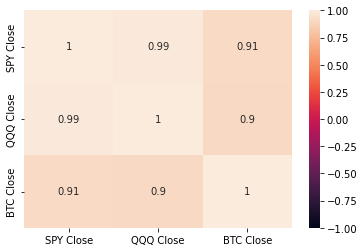

In [90]:
sns.heatmap(result.corr(), vmin=-1, vmax=1, annot=True)

In [91]:
result["Rolling Correlation BTC-SPY"] = result["BTC Close"].rolling(90).corr(result["SPY Close"])

In [92]:
result["Rolling Correlation BTC-QQQ"] = result["BTC Close"].rolling(90).corr(result["QQQ Close"])

In [93]:
result.dropna(inplace=True)
result

,SPY Close,QQQ Close,BTC Close,Rolling Correlation BTC-SPY,Rolling Correlation BTC-QQQ
Datetime,,,,,
2016-04-11,204.0201,108.60,428.20,0.337149,0.358771
2016-04-12,205.9200,109.51,427.80,0.401777,0.427189
2016-04-13,208.0008,110.91,425.58,0.445531,0.479922
2016-04-14,208.0100,110.92,428.04,0.490229,0.535464
2016-04-15,207.7800,110.64,430.93,0.552617,0.610989
...,...,...,...,...,...
2022-02-03,446.6000,353.55,37566.75,0.182924,0.426917
2022-02-04,448.7000,358.01,41557.54,0.173050,0.428301
2022-02-07,447.2600,355.13,44916.93,0.164540,0.427060


In [94]:
result.hvplot(x="Datetime", y=["Rolling Correlation BTC-QQQ", "Rolling Correlation BTC-SPY"], width=1300)

:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)